## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [2]:
data = pd.read_csv('data/ab_data_tourist.zip')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [4]:
data.date = pd.to_datetime(data.date)

## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [5]:
mask_a = data.group == 'A'
mask_b = data.group == 'B'
group_a = data[mask_a]
group_b = data[mask_b]
print(f'Посещения (А,В) - {group_a.shape[0], group_b.shape[0]}')
print(f'Покупки (А,В) - {group_a.purchase.sum(), group_b.purchase.sum()}')
print(f'Сумма покупок (А,В) - {group_a.price.sum()/1_000_000, group_b.price.sum()/1_000_000}')

Посещения (А,В) - (147202, 147276)
Покупки (А,В) - (17723, 17514)
Сумма покупок (А,В) - (1436.26, 1554.1)


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [6]:
visitors_a = set(group_a.user_id.values)
visitors_b = set(group_b.user_id.values)
visitors_both_version = tuple(visitors_a & visitors_b)
result = len(visitors_both_version)
result

1895

## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [7]:
updated_data = data[data['user_id'].apply(lambda x: x not in visitors_both_version)]
updated_data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

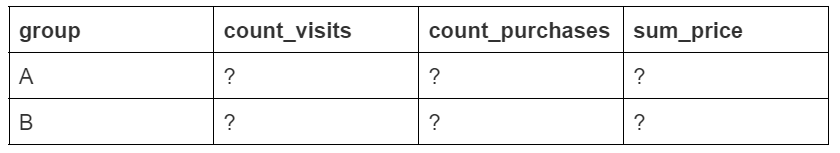
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [8]:
ab_table = updated_data.groupby(['group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price': 'sum'
}).reset_index().rename(columns={'user_id': 'count_visits','purchase': 'count_purchases','price': 'sum_price' })
ab_table

,group,count_visits,count_purchases,sum_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

### Количество посещений сопоставимо, выборки сбалансированы

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [9]:
ab_table['conversion'] = round(ab_table.count_purchases / ab_table.count_visits * 100, 2)
ab_table['mean_check'] = round(ab_table.sum_price / ab_table.count_purchases)
ab_table

,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,A,145307,17487,1417780000,12.03,81076.0
1,B,145381,17290,1533010000,11.89,88665.0


### Вариант А эффективнее варианта B по показателю "конверсии", но менее эффективен по показателю "средний чек"

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [10]:
pivot = updated_data.pivot_table(values='purchase', index='group', columns='price', aggfunc='sum')
pivot = pivot.drop(0, axis=1)
pivot

price,10000,60000,100000,150000,200000
group,,,,,
A,5182,5271,1832,3478,1724
B,5201,1730,5227,3438,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

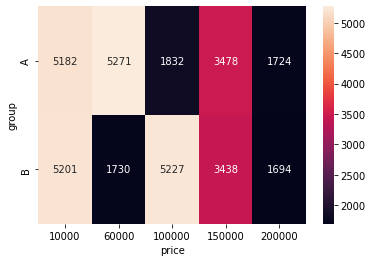

In [11]:
sns.heatmap(pivot, annot=True, fmt='.0f');

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

### Покупательная способность группы А выше в категории туров по цене 60 тыс. руб, в то время как участники группы В покупают значительно больше туров в категории 100 тыс. руб.

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [12]:
time_group = updated_data.groupby(['date', 'group']).agg({'user_id': 'count', 'purchase': 'sum', 'price': 'sum'}).reset_index()
time_group['conversion'] = round(time_group.purchase / time_group.user_id  *100, 2)
time_group['mean_check'] = round(time_group.price / time_group.purchase)
time_group.head(4)

,date,group,user_id,purchase,price,conversion,mean_check
0,2021-01-02,A,2854,359,29410000,12.58,81922.0
1,2021-01-02,B,2861,345,29660000,12.06,85971.0
2,2021-01-03,A,6596,748,62000000,11.34,82888.0
3,2021-01-03,B,6619,754,65960000,11.39,87480.0


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [13]:
time_group['cum_users'] = time_group.groupby('group')['user_id'].cumsum()
time_group['cum_purchase'] = time_group.groupby('group')['purchase'].cumsum()
time_group['cum_price'] = time_group.groupby('group')['price'].cumsum()
time_group['cum_conversion'] = round(time_group['cum_purchase'] / time_group['cum_users'] * 100, 2)
time_group['cum_mean_check'] = round(time_group['cum_price'] / time_group['cum_purchase'])
time_group.head()

,date,group,user_id,purchase,price,conversion,mean_check,cum_users,cum_purchase,cum_price,cum_conversion,cum_mean_check
0,2021-01-02,A,2854,359,29410000,12.58,81922.0,2854,359,29410000,12.58,81922.0
1,2021-01-02,B,2861,345,29660000,12.06,85971.0,2861,345,29660000,12.06,85971.0
2,2021-01-03,A,6596,748,62000000,11.34,82888.0,9450,1107,91410000,11.71,82575.0
3,2021-01-03,B,6619,754,65960000,11.39,87480.0,9480,1099,95620000,11.59,87006.0
4,2021-01-04,A,6566,799,64250000,12.17,80413.0,16016,1906,155660000,11.90,81668.0


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

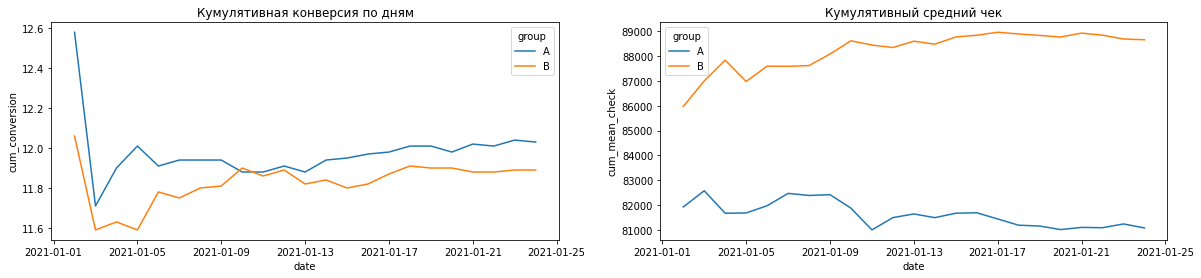

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(20, 4))
sns.lineplot(x='date', y='cum_conversion', data=time_group, hue='group', ax=axes[0])
sns.lineplot(x='date', y='cum_mean_check', data=time_group, hue='group', ax=axes[1])
axes[0].set_title('Кумулятивная конверсия по дням');
axes[1].set_title('Кумулятивный средний чек');

### Значения обоих метрик стабилизировались во времени. А/В тест можно считать завершенным. Кумулятивная конверсия в группе А с 13 января 2021 г. превышает конверсию в группе В. Кумулятивный средний чек по группе В, напротив, в течении всей продолжительности теста превышает средний чек по группе А

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [15]:
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'

alpha = 0.05

_, p_value = proportions_ztest(
    count=ab_table.count_purchases,
    nobs=ab_table.count_visits, 
    alternative='larger',
)
print('p-value: ', round(p_value, 2))
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

### Для проверки равенства конверсий (пропорций) применяю z-тест для пропорций. Тестирование показало, что p-value превышает уровень значимости альфа. Соответственно статистическая разница между конверсиями в группах А и В отсутствует. Принимаем нулевую гипотезу о равенстве конверсий в тестовых группах.

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [16]:
a_data = updated_data[updated_data.group == 'A']
b_data = updated_data[updated_data.group == 'B']

def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma
    z_crit = -norm.ppf(alpha/2)
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5
    lower_bound = x_p - eps
    upper_bound = x_p + eps
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

conf_interval_a = proportions_conf_interval(
    n=a_data['user_id'].count(),
    x_p=a_data['purchase'].mean()
)
conf_interval_b = proportions_conf_interval(
    n=b_data['user_id'].count(),
    x_p=b_data['purchase'].mean()
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

### Доверительные интервалы для конверсий в тестовых группах пересекаются, следовательно существует вероятность, что истинная величина конверсий в обеих группах может совпадать. Рассчет доверительного интервала разницы конверсий (ниже) показал, что нулевая точка включается в доверительный интервал, что подтверждает гипотезу о равенстве конверсий в тестовых группах.

In [17]:
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma
    diff = xp[1] - xp[0]
    z_crit = -norm.ppf(alpha/2)
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5
    lower_bound = diff - eps
    upper_bound = diff + eps
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

n = [a_data['user_id'].count(), b_data['user_id'].count()]
xp = [a_data['purchase'].mean(), b_data['purchase'].mean()]
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для разности конверсий: (-0.38, 0.09)


## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

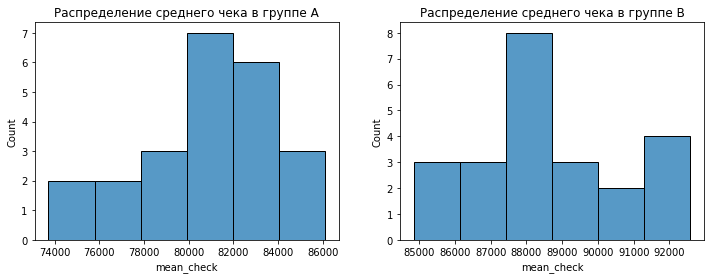

In [20]:
mask_a = time_group.group == 'A'
mask_b = time_group.group == 'B'

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(x='mean_check', data=time_group[mask_a], ax=axes[0])
sns.histplot(x='mean_check', data=time_group[mask_b], ax=axes[1])
axes[0].set_title('Распределение среднего чека в группе А');
axes[1].set_title('Распределение среднего чека в группе B');

In [24]:
H0 = 'Средний чек в группе А распределен нормально'
Ha = 'Средний чек в группе А не распределен нормально (мы отвергаем H0)'
alpha = 0.05
_, p = shapiro(time_group[mask_a]['mean_check'])
if p > alpha:
	print(f'p = {round(p,3)}, {H0}')
else:
	print(f'p = {round(p,3)}, {Ha}')
 
H0 = 'Средний чек в группе B распределен нормально'
Ha = 'Средний чек в группе B не распределен нормально (мы отвергаем H0)'
alpha = 0.05
_, p = shapiro(time_group[mask_b]['mean_check'])
if p > alpha:
	print(f'p = {round(p,3)}, {H0}')
else:
	print(f'p = {round(p,3)}, {Ha}')

p = 0.253, Средний чек в группе А распределен нормально
p = 0.094, Средний чек в группе B распределен нормально


## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [31]:
H0 = 'Средние чеки в группах одинаковы'
H1 = 'Средний чек в группе А меньше, чем в группе B'
alpha = 0.05
results = ttest_ind(
    a=time_group[mask_a]['mean_check'],
    b=time_group[mask_b]['mean_check'], 
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print(f"Отвергаем нулевую гипотезу - '{H0}'")
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value: 0.0
Отвергаем нулевую гипотезу - 'Средние чеки в группах одинаковы'
Альтернативная гипотеза. H1: Средний чек в группе А меньше, чем в группе B


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

### Значение p-value ниже уровня значимости, соответственно можно сделать вывод о существовании статистической разницы между ежедневными средними чеками в тестовых группах, причем средний чек в группе В превышает средний чек группы А

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [33]:
def conf_interval(n, x_std, x_mean, gamma = 0.95):
    alpha = 1 - gamma
    k = n - 1 
    t_crit = -t.ppf(alpha/2, k) 
    eps = t_crit * x_std/(n ** 0.5) 
    lower_bound = x_mean - eps
    upper_bound = x_mean + eps
    return (round(lower_bound), round(upper_bound)) 

conf_interval_a = conf_interval(
    n = len(time_group[mask_a]['mean_check']),
    x_std = time_group[mask_a]['mean_check'].std(),
    x_mean = time_group[mask_a]['mean_check'].mean()
    )
conf_interval_b = conf_interval(
    n = len(time_group[mask_b]['mean_check']),
    x_std = time_group[mask_b]['mean_check'].std(),
    x_mean = time_group[mask_b]['mean_check'].mean()
    )

print('Доверительный интервал группы А: {}'.format(conf_interval_a)) 
print('Доверительный интервал группы В: {}'.format(conf_interval_b)) 


Доверительный интервал группы А: (79630, 82308)
Доверительный интервал группы В: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

### Расчеты доверительных интервалов средних чеков в тестовых группах показали, что между ними нет пересечений. таким образом гипотеза о существенном превышении среднего чека в группе В подтверждается

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

### Итак, проведенный А/В тест показал, что не смотря на несущественное превышение метрики конверсии в группе А, этот факт нельзя считать статистически значимым с большой долей вероятности. Таким образом изначальный вариант сайта не имеет большую долю конверсии по сравнению с тестовым вариантом. В то время как последний влечет значительное увеличение среднего чека, что приводит к существенному увеличению выручки. Таким образом вывод однозначный - переходить на новый вариант сайта.